# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np

import plotly.express as xp
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import pickle

# **Load Data**

In [2]:
import pandas as pd

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


# **Data Preprocessing**

In [3]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [6]:
df.describe(include=[object])

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


## Handling Missing Value

In [7]:
df.drop(columns = ['customerID'], inplace = True)

In [8]:
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [9]:
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [10]:
df.dropna(inplace=True)

In [11]:
df.shape

(7032, 20)

In [12]:
df.duplicated().sum()

22

## Data separation as X and y

In [13]:
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7032, dtype: int64

In [14]:
X = df.drop('Churn', axis=1)
X

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60


## Data Splitting

In [15]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
X_train

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6030,Female,0,No,No,43,No,No phone service,DSL,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),49.05,2076.20
3410,Male,0,No,No,3,Yes,No,DSL,No,No,No,No,Yes,No,Month-to-month,No,Credit card (automatic),53.40,188.70
5483,Female,0,Yes,No,55,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,77.75,4458.15
5524,Male,0,Yes,Yes,45,Yes,No,DSL,Yes,No,No,Yes,No,No,Two year,No,Bank transfer (automatic),54.65,2553.70
6337,Female,0,Yes,Yes,55,Yes,Yes,Fiber optic,Yes,No,No,No,Yes,Yes,One year,No,Mailed check,100.90,5448.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3778,Male,0,No,No,3,Yes,Yes,DSL,No,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),50.40,137.25
5199,Female,0,No,No,51,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,111.50,5703.25
5235,Male,0,No,No,9,Yes,Yes,Fiber optic,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,81.15,784.45
5399,Female,0,No,No,50,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),19.75,989.05


In [17]:
X_test

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2481,Male,1,Yes,No,61,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),25.00,1501.75
6784,Female,0,No,No,19,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),24.70,465.85
6125,Male,0,Yes,No,13,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),102.25,1359.00
3052,Male,0,Yes,No,37,Yes,Yes,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Mailed check,55.05,2030.75
4099,Female,0,No,No,6,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),29.45,161.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.05,19.05
5250,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Electronic check,94.55,1173.55
5465,Female,0,No,No,26,Yes,No,DSL,No,Yes,Yes,No,No,No,One year,Yes,Mailed check,56.05,1553.20
5851,Female,1,No,No,35,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),110.80,3836.30


## Validate Categorical Data

In [18]:
def validate_test_data_categorical_columns(train_df, test_df):
    # Get the list of categorical columns for both train and test DataFrames
    train_df_categorical_columns = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
    test_df_categorical_columns = test_df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Check if the number of categorical columns is the same in both DataFrames
    if len(set(train_df_categorical_columns).intersection(set(test_df_categorical_columns))) == 0:
        print('Train and test dataframes have different categorical columns')
        return
    else:
        for cat_col in test_df_categorical_columns:
            # Create sets of unique values for the current categorical column in both DataFrames
            train_col = set(x for x in train_df[cat_col].unique().tolist() if not pd.isna(x))
            test_col = set(x for x in test_df[cat_col].unique().tolist() if not pd.isna(x))

            # Check if the sets are not equal, indicating different unique values
            if train_col != test_col:
                print(f'{cat_col} column has different unique values in train and test data:')
                print(f'Unique values in train data: {train_col}')
                print(f'Unique values in test data: {test_col}')
                return

        print('All categorical columns have consistent unique values in train and test data.')
        return

validate_test_data_categorical_columns(X_train, X_test)

All categorical columns have consistent unique values in train and test data.


## Encoding Categorical Data

In [19]:
label_encoder = LabelEncoder()

categorical_columns = [
    'gender', 
    'Partner',
    'Dependents',
    'PhoneService',
    'PaperlessBilling' , 
    'Contract', 
    'MultipleLines', 
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies',
    'PaymentMethod'
]

label_encoders = {}

for column in categorical_columns:
    # Fit and transform the column
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    # Save the encoder
    label_encoders[column] = le

print("Encoded DataFrame:")
df.head()

Encoded DataFrame:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,No
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,No
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,Yes
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,No
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,Yes


In [20]:
print("Label Encoding Mapping:")
for column, le in label_encoders.items():
    print(f"\nColumn: {column}")
    for i, label in enumerate(le.classes_):
        print(f"{i}: {label}")

Label Encoding Mapping:

Column: gender
0: Female
1: Male

Column: Partner
0: No
1: Yes

Column: Dependents
0: No
1: Yes

Column: PhoneService
0: No
1: Yes

Column: PaperlessBilling
0: No
1: Yes

Column: Contract
0: Month-to-month
1: One year
2: Two year

Column: MultipleLines
0: No
1: No phone service
2: Yes

Column: InternetService
0: DSL
1: Fiber optic
2: No

Column: OnlineSecurity
0: No
1: No internet service
2: Yes

Column: OnlineBackup
0: No
1: No internet service
2: Yes

Column: DeviceProtection
0: No
1: No internet service
2: Yes

Column: TechSupport
0: No
1: No internet service
2: Yes

Column: StreamingTV
0: No
1: No internet service
2: Yes

Column: StreamingMovies
0: No
1: No internet service
2: Yes

Column: PaymentMethod
0: Bank transfer (automatic)
1: Credit card (automatic)
2: Electronic check
3: Mailed check


In [21]:
for column in categorical_columns:
  le.fit(X_train[column])
  X_train[column] = le.transform(X_train[column])

for column in categorical_columns:
  le.fit(X_test[column])
  X_test[column] = le.transform(X_test[column])

In [22]:
label_encoders = {
    'gender': LabelEncoder().fit(['Female', 'Male']),
    'Partner': LabelEncoder().fit(['No', 'Yes']),
    'Dependents': LabelEncoder().fit(['No', 'Yes']),
    'PhoneService': LabelEncoder().fit(['No', 'Yes']),
    'PaperlessBilling': LabelEncoder().fit(['No', 'Yes']),
    'Contract': LabelEncoder().fit(['Month-to-month', 'One year', 'Two year']),
    'MultipleLines': LabelEncoder().fit(['No', 'No phone service', 'Yes']),
    'InternetService': LabelEncoder().fit(['DSL', 'Fiber optic', 'No']),
    'OnlineSecurity': LabelEncoder().fit(['No', 'No internet service', 'Yes']),
    'OnlineBackup': LabelEncoder().fit(['No', 'No internet service', 'Yes']),
    'DeviceProtection': LabelEncoder().fit(['No', 'No internet service', 'Yes']),
    'TechSupport': LabelEncoder().fit(['No', 'No internet service', 'Yes']),
    'StreamingTV': LabelEncoder().fit(['No', 'No internet service', 'Yes']),
    'StreamingMovies': LabelEncoder().fit(['No', 'No internet service', 'Yes']),
    'PaymentMethod': LabelEncoder().fit(['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check'])
}

# Saving the encoder to a file
with open('encoder.pkl', 'wb') as file:
    pickle.dump(label_encoders, file)

# Exploratory Data Analysis

In [23]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()

features = ['MonthlyCharges', 'TotalCharges', 'tenure']
df[features] = scaler.fit_transform(df[features])

# **Model Building**

In [24]:
def k_fold_cross_validation_with_metrics(classifier, X, y, k_folds=5):
    
    # Initializing stratified k-fold cross-validation
    stratified_kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Lists to store the evaluation metrics for each fold
    accuracy_scores = []
    precision_scores = []
    recall_scores = []

    # Perform cross-validation
    for train_index, test_index in stratified_kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the classifier on the training data
        classifier.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = classifier.predict(X_test)

        # Calculate evaluation metrics for this fold
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        # Append the metrics to their respective lists
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)

    # Calculate and print the mean of each metric across all folds
    mean_accuracy = np.mean(accuracy_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    print("Mean Metrics Across Folds:")
    print(f"Mean Accuracy: {mean_accuracy:.2f}")
    print(f"Mean Precision: {mean_precision:.2f}")
    print(f"Mean Recall: {mean_recall:.2f}")

## **K Nearest Neighbour (KNN)**

### **Training the Model**

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

### **Applying the Model to make a Prediction**

In [26]:
y_knn_pred = knn.predict(X_test)

In [27]:
y_knn_pred

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

### **Evaluate Model Performance**

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

accuracy_knn = accuracy_score(y_test, y_knn_pred)
precision_knn = precision_score(y_test, y_knn_pred, average = 'weighted')
recall_knn = recall_score(y_test, y_knn_pred, average = 'weighted')
f1_knn = f1_score(y_test, y_knn_pred, average = 'weighted')
confusion_matrix = confusion_matrix(y_test, y_knn_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])

print('Accuracy:', accuracy_knn)
print('Precision:', precision_knn)
print('Recall:', recall_knn)
print('F1 Score:', f1_knn)
print()
print(classification_report(y_test, y_knn_pred))
print(confusion_matrix)

Accuracy: 0.7725657427149965
Precision: 0.7576476113656205
Recall: 0.7725657427149965
F1 Score: 0.7608715356299744

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1033
           1       0.60      0.44      0.51       374

    accuracy                           0.77      1407
   macro avg       0.71      0.67      0.68      1407
weighted avg       0.76      0.77      0.76      1407

[[921 112]
 [208 166]]


In [29]:
knn_results = pd.DataFrame(['K Nearest Neighbour', accuracy_knn, precision_knn, recall_knn, f1_knn]).transpose()
knn_results.columns = ['Method', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

In [30]:
knn_results

,Method,Accuracy,Precision,Recall,F1 Score
0,K Nearest Neighbour,0.772566,0.757648,0.772566,0.760872


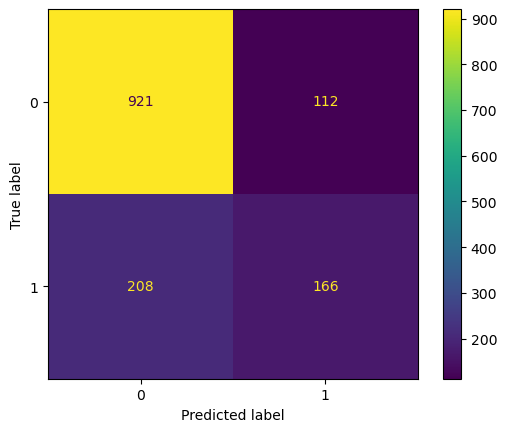

In [31]:
cm_display.plot()
plt.show()

## **Support Vector Machines (SVM)**



### **Training the Model**

In [32]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train)

SVC()

### **Applying the Model to make a Prediction**

In [33]:
y_svm_pred = svm.predict(X_test)

In [34]:
y_svm_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### **Evaluate Model Performance**

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

accuracy_svm = accuracy_score(y_test, y_svm_pred)
precision_svm = precision_score(y_test, y_svm_pred, average = 'weighted')
recall_svm = recall_score(y_test, y_svm_pred, average = 'weighted')
f1_svm = f1_score(y_test, y_svm_pred, average = 'weighted')
confusion_matrix = confusion_matrix(y_test, y_svm_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])

print('Accuracy:', accuracy_svm)
print('Precision:', precision_svm)
print('Recall:', recall_svm)
print('F1 Score:', f1_svm)
print()
print(classification_report(y_test, y_svm_pred))

Accuracy: 0.7341862117981521
Precision: 0.5390293935945211
Recall: 0.7341862117981521
F1 Score: 0.6216511121208944

              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1033
           1       0.00      0.00      0.00       374

    accuracy                           0.73      1407
   macro avg       0.37      0.50      0.42      1407
weighted avg       0.54      0.73      0.62      1407



In [36]:
svm_results = pd.DataFrame(['Support Vector Machines', accuracy_svm, precision_svm, recall_svm, f1_svm]).transpose()
svm_results.columns = ['Method', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

In [37]:
svm_results

,Method,Accuracy,Precision,Recall,F1 Score
0,Support Vector Machines,0.734186,0.539029,0.734186,0.621651


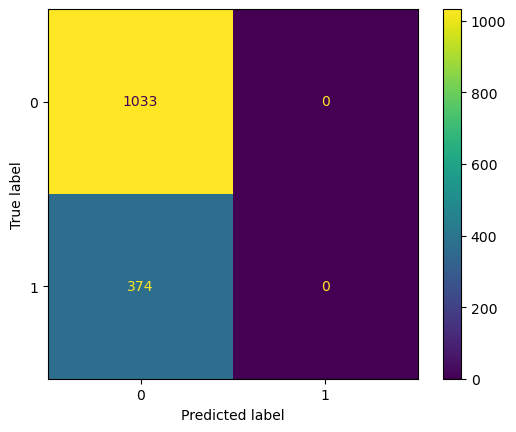

In [38]:
cm_display.plot()
plt.show()

## **Logistic Regression**

### **Training the Model**

In [39]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000) #the max iter need to be removed after done the data prep processing
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### **Applying the Model to make a Prediction**

In [40]:
y_lr_pred = lr.predict(X_test)

In [41]:
y_lr_pred

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

### **Evaluate Model Performance**

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

accuracy_lr = accuracy_score(y_test, y_lr_pred)
precision_lr = precision_score(y_test, y_lr_pred, average = 'weighted')
recall_lr = recall_score(y_test, y_lr_pred, average = 'weighted')
f1_lr = f1_score(y_test, y_lr_pred, average = 'weighted')
confusion_matrix = confusion_matrix(y_test, y_lr_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])

print('Accuracy:', accuracy_lr)
print('Precision:', precision_lr)
print('Recall:', recall_lr)
print('F1 Score:', f1_lr)
print()
print(classification_report(y_test, y_lr_pred))

Accuracy: 0.7874911158493249
Precision: 0.7760977478000974
Recall: 0.7874911158493249
F1 Score: 0.7788572135536863

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



In [43]:
lr_results = pd.DataFrame(['Logistic Regression', accuracy_lr, precision_lr, recall_lr, f1_lr]).transpose()
lr_results.columns = ['Method', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

In [44]:
lr_results

,Method,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.787491,0.776098,0.787491,0.778857


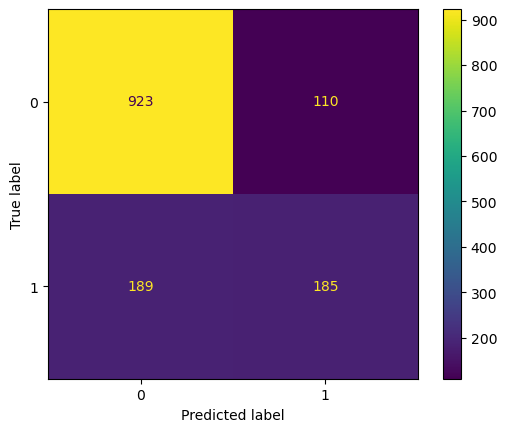

In [45]:
cm_display.plot()
plt.show()

In [46]:
k_fold_cross_validation_with_metrics(lr, X_train, y_train)

Mean Metrics Across Folds:
Mean Accuracy: 0.80
Mean Precision: 0.65
Mean Recall: 0.56


## **Decision Tree**

### **Training the Model**

In [47]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

### **Applying the Model to make a Prediction**

In [48]:
y_dt_pred = dt.predict(X_test)

In [49]:
y_dt_pred

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

### **Evaluate Model Performance**

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

accuracy_dt = accuracy_score(y_test, y_dt_pred)
precision_dt = precision_score(y_test, y_dt_pred, average = 'weighted')
recall_dt = recall_score(y_test, y_dt_pred, average = 'weighted')
f1_dt = f1_score(y_test, y_dt_pred, average = 'weighted')
confusion_matrix = confusion_matrix(y_test, y_dt_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])

print('Accuracy:', accuracy_dt)
print('Precision:', precision_dt)
print('Recall:', recall_dt)
print('F1 Score:', f1_dt)
print()
print(classification_report(y_test, y_dt_pred))

Accuracy: 0.7171286425017769
Precision: 0.7270426062378555
Recall: 0.7171286425017769
F1 Score: 0.72151570636424

              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1033
           1       0.47      0.52      0.49       374

    accuracy                           0.72      1407
   macro avg       0.65      0.65      0.65      1407
weighted avg       0.73      0.72      0.72      1407



In [51]:
dt_results = pd.DataFrame(['Decision Tree', accuracy_dt, precision_dt, recall_dt, f1_dt]).transpose()
dt_results.columns = ['Method', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

In [52]:
dt_results

,Method,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.717129,0.727043,0.717129,0.721516


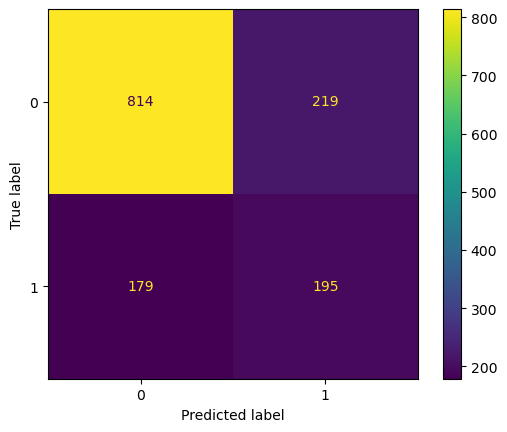

In [53]:
cm_display.plot()
plt.show()

## **Random Forest**

### **Training the Model**

In [54]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

### **Applying the Model to make a Prediction**

In [55]:
y_rf_pred = rf.predict(X_test)

In [56]:
y_rf_pred

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

### **Evaluate Model Performance**

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

accuracy_rf = accuracy_score(y_test, y_rf_pred)
precision_rf = precision_score(y_test, y_rf_pred, average = 'weighted')
recall_rf = recall_score(y_test, y_rf_pred, average = 'weighted')
f1_rf = f1_score(y_test, y_rf_pred, average = 'weighted')
confusion_matrix = confusion_matrix(y_test, y_rf_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])

print('Accuracy:', accuracy_rf)
print('Precision:', precision_rf)
print('Recall:', recall_rf)
print('F1 Score:', f1_rf)
print()
print(classification_report(y_test, y_rf_pred))

Accuracy: 0.7867803837953091
Precision: 0.7738824889369856
Recall: 0.7867803837953091
F1 Score: 0.7760967624379921

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.47      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407



In [58]:
rf_results = pd.DataFrame(['Random Forest', accuracy_rf, precision_rf, recall_rf, f1_rf]).transpose()
rf_results.columns = ['Method', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

In [59]:
rf_results

,Method,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.78678,0.773882,0.78678,0.776097


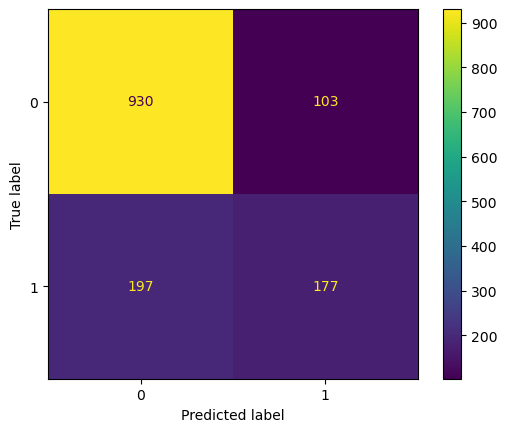

In [60]:
cm_display.plot()
plt.show()

In [61]:
# from sklearn.model_selection import GridSearchCV

# # For Random Forest
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 20],
#     'min_samples_split': [2, 5]
# }
# grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)

## **Artificial Neural Network (ANN) accuracy veliveli low**

### **Training the Model**

In [63]:
# import keras
# from keras.models import Sequential
# from keras.layers import Dense

# # Create the model
# ann_model = Sequential()
# ann_model.add(Dense(6, activation = 'relu', input_dim = 12))
# ann_model.add(Dense(6, activation = 'relu'))
# ann_model.add(Dense(1, activation = 'sigmoid'))

# # ann_model.add(Dense(12, input_dim=13, activation='relu'))
# # ann_model.add(Dense(8, activation='relu'))
# # ann_model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# ann_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train the model
# # ann_model.fit(X_train, y_train, epochs=150, batch_size=10, verbose=0)
# ann_model.fit(X_train, y_train, batch_size = 10, epochs = 100)

# # Predictions
# # y_pred_ann = (ann_model.predict(X_test) > 0.5).astype("int32")
# y_pred_ann = ann_model.predict(X_test)
# y_pred_ann = (y_pred_ann > 0.5)

# # Evaluate
# accuracy_ann = accuracy_score(y_test, y_pred_ann)
# precision_ann = precision_score(y_test, y_pred_ann, average = 'weighted')
# recall_ann = recall_score(y_test, y_pred_ann, average = 'weighted')

# print(classification_report(y_test, y_pred_ann))

# **Model Comparison**

In [1508]:
df_models = pd.concat([knn_results, svm_results, lr_results, dt_results, rf_results], axis=0)
df_models.reset_index(drop=True)

,Method,Accuracy,Precision,Recall,F1 Score
0,K Nearest Neighbour,0.772566,0.757648,0.772566,0.760872
1,Support Vector Machines,0.734186,0.539029,0.734186,0.621651
2,Logistic Regression,0.787491,0.776098,0.787491,0.778857
3,Decision Tree,0.7285,0.733212,0.7285,0.730709
4,Random Forest,0.778962,0.765181,0.778962,0.768031


In [1509]:
with open("customer_churn_random_forest_model.pkl", 'wb') as model_file:
    pickle.dump(rf, model_file)

# **Deployment of Prediction**

In [1510]:
class CustomerChurnClassifier:
    
    def __init__(self, model_path, encoder_path):
        # Load the model
        with open(model_path, 'rb') as file:
            self.model = pickle.load(file)
        
        # Load the LabelEncoders
        with open(encoder_path, 'rb') as file:
            self.encoders = pickle.load(file)
    
    def predict(self, tenure: int, phone_service: str, multiple_lines: str, internet_service: str, online_security: str, online_backup: str, device_protection: str, tech_support: str, streaming_tv: str, streaming_movies: str, contract: str, paperless_billing: str, payment_method: str, monthly_charges: float, total_charges: float, gender: str, senior_citizen: int, partner: str, dependents: str):
        
        # Checking input datatypes
        expected_data_types = [int, str, str, str, str, str, str, str, str, str, str, str, str, float, float, str, int, str, str]
        input_arguments = [tenure, phone_service, multiple_lines, internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, contract, paperless_billing, payment_method, monthly_charges, total_charges, gender, senior_citizen, partner, dependents]
        input_arguments_names = ['tenure', 'phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'gender', 'senior_citizen', 'partner', 'dependents']

        for i in range(len(input_arguments)):
            current_arg_type = type(input_arguments[i])
            if current_arg_type != expected_data_types[i]:
                raise TypeError(f"Error: Given {input_arguments_names[i]} ({current_arg_type.__name__}) is not of the expected type ({expected_data_types[i].__name__}).")
        
        # Transform categorical features using LabelEncoder
        encoded_features = [
            self.encoders['gender'].transform([gender])[0],
            self.encoders['Partner'].transform([partner])[0],
            self.encoders['Dependents'].transform([dependents])[0],
            self.encoders['PhoneService'].transform([phone_service])[0],
            self.encoders['MultipleLines'].transform([multiple_lines])[0],
            self.encoders['InternetService'].transform([internet_service])[0],
            self.encoders['OnlineSecurity'].transform([online_security])[0],
            self.encoders['OnlineBackup'].transform([online_backup])[0],
            self.encoders['DeviceProtection'].transform([device_protection])[0],
            self.encoders['TechSupport'].transform([tech_support])[0],
            self.encoders['StreamingTV'].transform([streaming_tv])[0],
            self.encoders['StreamingMovies'].transform([streaming_movies])[0],
            self.encoders['Contract'].transform([contract])[0],
            self.encoders['PaperlessBilling'].transform([paperless_billing])[0],
            self.encoders['PaymentMethod'].transform([payment_method])[0]
        ]
        
        # Combine numerical and encoded features
        to_predict_array = [senior_citizen, tenure, monthly_charges, total_charges] + encoded_features
        to_predict_array = np.array(to_predict_array).reshape((1, -1))
        
        # Make prediction
        prediction = self.model.predict(to_predict_array)[0]

        if prediction > 0.5:
            return 'Will Churn'
        else:
            return "Won't Churn"

In [1511]:
customer_churn = CustomerChurnClassifier(
    model_path = 'customer_churn_random_forest_model.pkl', 
    encoder_path = 'encoder.pkl'
)

In [1512]:
customer_churn.predict(
    tenure=18,
    phone_service='No',
    multiple_lines='No phone service',
    internet_service='DSL',
    online_security='No',
    online_backup='No',
    device_protection='Yes',
    tech_support='No',
    streaming_tv='Yes',
    streaming_movies='No',
    contract='Month-to-month',
    paperless_billing='No',
    payment_method='Electronic check',
    monthly_charges=70.50,
    total_charges=1250.00,
    gender='Female',
    senior_citizen=0,
    partner='No',
    dependents='Yes'
)

0


"Won't Churn"